In [3]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 11.5 MB/s eta 0:00:00


In [5]:
!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.4 MB/s eta 0:00:00


In [7]:
!pip install powerlaw

In [8]:
import pandas as pd
import numpy as np
import zstandard as zstd
import os
import random
import xlsxwriter

import networkx as nx
from networkx import bipartite_layout
from networkx.algorithms import community, bipartite
import igraph as ig

import powerlaw
import matplotlib.pyplot as plt
import seaborn
import scipy

In [9]:
contracts = pd.read_csv('/content/contracts.csv')
aggregated_country_year = pd.read_csv('/content/aggregated_country_year.csv')

In [10]:
print(len(contracts))
print(len(aggregated_country_year))

1905775
234


In [11]:
contracts = contracts.drop(['Unnamed: 0'], axis=1)
contracts.head(3)

tender_id  year date_dispatched issuer_id_final  \
0  2.150556e+09  2008      2008-12-11        248_LV_i   
1  2.152665e+09  2012      2012-12-20        295_UK_i   
2  2.224763e+09  2008      2008-01-02       4555_PL_i   

                                         issuer_name  \
0  Rēzeknes pilsētas Izglītības pārvalde, LV90000...   
1  Chelsea & Westminster Hospital NHS Foundation ...   
2                    Zarząd Dróg i Zieleni w Gdańsku   

                               issuer_canonical_name issuer_country  \
0  rezeknes pilsetas izglitibas parvalde lv900000...             LV   
1  chelsea westminster hospital nhs foundation tr...             UK   
2                  zarzad drog i zieleni w gdansku_i             PL   

          issuer_address issuer_postcode issuer_town  ... contract_nuts  \
0  Atbrīvošanas aleja 91            4600     Rēzekne  ...         LV005   
1        369 Fulham Road        SW10 9NH      London  ...           NaN   
2     ul. Partyzantów 36          80-254      Gdańsk  ...           NaN   

  processed_nuts contract_cpv  cpv2 contract_eu_funded contract_type  \
0           LV00   74200000.0  74.0                0.0   1. Services   
1             UK   33111800.0  33.0                0.0   2. Supplies   
2             PL   45233141.0  45.0                0.0      3. Works   

    procedure n_bids nocft  single_bidder  
0        open    4.0   0.0            0.0  
1  restricted    4.0   1.0            0.0  
2        open    1.0   0.0            1.0  

[3 rows x 31 columns]

In [12]:
aggregated_country_year = aggregated_country_year.drop(['Unnamed: 0'], axis=1)
aggregated_country_year.head(3)

country  year  ncontracts   sb_rate  nwinners  nissuers  nedges  \
0      AT  2008        3192  0.094337      1815       456    2324   
1      AT  2009        3148  0.100352      1906       429    2482   
2      AT  2010        3178  0.105601      1762       386    2339   

   non_core_sb_rate  core_ncontracts  core_sb_rate  ...  core_density  \
0          0.121861              718      0.101374  ...      0.011840   
1          0.074037              500      0.118953  ...      0.012833   
2          0.149497              647      0.091780  ...      0.011105   

   core_to_non_sb  core_contract_share  eqi_score  ti_cpi  wbgi_cce  \
0        1.074591             0.224937        NaN    81.0  1.843035   
1        1.185354             0.158831        NaN    79.0  1.703025   
2        0.869121             0.203587    1.06285    79.0  1.585462   

   vdem_corr  sb_rate_08_16  sb_clustering_vs_random  sb_core_vs_random  
0   0.139032       0.121968                 2.088365           0.902565  
1   0.139032       0.121968                 3.600993           0.945130  
2   0.139032       0.121968                 1.888154           0.796586  

[3 rows x 23 columns]

In [13]:
# Define a dictionary that maps each country to a color
country_colors_dict = {
    'AT': 'red',
    'BE': 'blue',
    'BG': 'green',
    'CY': 'purple',
    'CZ': 'orange',
    'DE': 'yellow',
    'DK': 'cyan',
    'EE': 'magenta',
    'ES': 'lime',
    'FI': 'teal',
    'FR': 'pink',
    'GR': 'brown',
    'HU': 'gray',
    'IE': 'navy',
    'IT': 'olive',
    'LT': 'maroon',
    'LV': 'gold',
    'NL': 'indigo',
    'NO': 'darkred',
    'PL': 'darkgreen',
    'PT': 'darkorange',
    'RO': 'darkcyan',
    'SE': 'darkmagenta',
    'SI': 'seagreen',
    'SK': 'sienna',
    'UK': 'slateblue'
}

aggregated_country_year['issuer_country'] = aggregated_country_year['country']
aggregated_country_year['winner_country'] = aggregated_country_year['country']

aggregated_country_year['issuer_color'] = aggregated_country_year['issuer_country'].map(country_colors_dict)
aggregated_country_year['winner_color'] = aggregated_country_year['winner_country'].map(country_colors_dict)

In [14]:
# merge contracts and aggregated_country_year country and year
contracts_merged = contracts.merge(aggregated_country_year.drop(['winner_country', 'winner_color'], axis=1), how='left', left_on=['issuer_country', 'year'], right_on=['issuer_country', 'year'])

contracts_merged = contracts_merged.merge(aggregated_country_year[['winner_country', 'winner_color', 'year']], how='left', left_on=['winner_country', 'year'], right_on=['winner_country', 'year'])

In [15]:
contracts_merged['tender_id'].nunique()

1905775

In [16]:
# add dummy if single_bidder > 50% (above annual market single bidding rate per country)
contracts_merged['sbr_above_50'] = contracts_merged['single_bidder'].apply(lambda x: 1 if x > 0.5 else 0)

In [17]:
# add dummy if single_bidder above annual aberage market single bidding rate per country
contracts_merged['sbr_above_ave'] = (contracts_merged['single_bidder'] > contracts_merged['sb_rate']).astype(int)

In [18]:
sum(contracts_merged['sbr_above_50']==1)/len(contracts_merged.index)

0.19073920058768742

In [19]:
len(contracts_merged.index)

1905775

In [20]:
contracts_merged['player'] = "issuer"
contracts_merged['player'] = "winner"

In [21]:
contracts_merged_DE = contracts_merged[contracts_merged['issuer_country']=="DE"]
contracts_merged_DE = contracts_merged_DE.reset_index(drop=True)

In [22]:
# add weights - number of contracts the nodes are involved in
contracts_merged_DE.loc[:, 'count'] = contracts_merged_DE.groupby(['issuer_id_final', 'winner_id_final', 'year', 'issuer_country'])['issuer_id_final'].transform('size')
contracts_merged_DE.loc[:, 'count_awarded'] = contracts_merged_DE.groupby(['issuer_id_final', 'year', 'issuer_country'])['issuer_id_final'].transform('size')
contracts_merged_DE.loc[:, 'count_won'] = contracts_merged_DE.groupby(['winner_id_final', 'year', 'issuer_country'])['winner_id_final'].transform('size')

In [23]:
contracts_merged_DE['sbr_above_ave'].value_counts()

sbr_above_ave
0    99190
1    19509
Name: count, dtype: int64

In [24]:
contracts_merged_DE['sbr_above_50'].value_counts()

sbr_above_50
0    106898
1     11801
Name: count, dtype: int64

In [25]:
contracts_merged_DE['sb_rate'].value_counts()

sb_rate
0.127696    30204
0.105027    28710
0.115622    23789
0.084924    19627
0.109088    16369
Name: count, dtype: int64

In [26]:
# create full DE subgraph
DE = nx.from_pandas_edgelist(contracts_merged_DE, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'count', 'n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'sbr_above_ave', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

# set node attributes for issuer
issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
issuer_attributes = contracts_merged[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
nx.set_node_attributes(DE, issuer_attributes, 'issuer')

# set node attributes for winner
winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
winner_attributes = contracts_merged[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
nx.set_node_attributes(DE, winner_attributes, 'winner')

bipartite.is_bipartite(DE)

nodes_i = [node for node in DE if node.endswith('i')]
nodes_w = [node for node in DE if node.endswith('w')]

In [27]:
# print basic information about the graph
print("Number of nodes:", DE.number_of_nodes())
print("Number of edges:", DE.number_of_edges())

degrees = [deg for node, deg in DE.degree()]
avg_degree = sum(degrees)/len(DE)
print("Average degree: {:.2f}".format(round(avg_degree, 2)))

density = bipartite.density(DE, nodes_i)
print("Network density: {:.10f}".format(round(density, 2)))

density = bipartite.density(DE, nodes_w)
print("Network density: {:.10f}".format(round(density, 2)))

degrees_i = [deg for node, deg in DE.degree() if node.endswith('i')]
avg_degree_i = sum(degrees_i)/len(degrees_i)
std_dev_i = np.nanstd(degrees_i)

degrees_w = [deg for node, deg in DE.degree() if node.endswith('w')]
avg_degree_w = sum(degrees_w)/len(degrees_w)
std_dev_w = np.nanstd(degrees_w)

print("Average degree issuer: {:.2f}".format(round(avg_degree_i, 2)))
print("Average degree winner: {:.2f}".format(round(avg_degree_w, 2)))

# bipartite.degrees(DE, [node for node in DE if node.endswith('w')])

Number of nodes: 49682
Number of edges: 118699
Average degree: 4.78
Network density: 0.0000000000
Network density: 0.0000000000
Average degree issuer: 13.51
Average degree winner: 2.90


In [28]:
connected_component_subgraphs = (DE.subgraph(c) for c in nx.connected_components(DE))

DE_largest_subgraph = max(connected_component_subgraphs, key=len)

In [29]:
# print basic information about the graph
print("Number of nodes:", DE_largest_subgraph.number_of_nodes())
print("Number of edges:", DE_largest_subgraph.number_of_edges())

degrees = [deg for node, deg in DE_largest_subgraph.degree()]
avg_degree = sum(degrees)/len(DE_largest_subgraph)
print("Average degree: {:.2f}".format(round(avg_degree, 2)))

density = bipartite.density(DE_largest_subgraph, nodes_i)
print("Network density: {:.10f}".format(round(density, 2)))

density = bipartite.density(DE_largest_subgraph, nodes_w)
print("Network density: {:.10f}".format(round(density, 2)))

degrees_i = [deg for node, deg in DE_largest_subgraph.degree() if node.endswith('i')]
avg_degree_i = sum(degrees_i)/len(degrees_i)
std_dev_i = np.nanstd(degrees_i)

degrees_w = [deg for node, deg in DE_largest_subgraph.degree() if node.endswith('w')]
avg_degree_w = sum(degrees_w)/len(degrees_w)
std_dev_w = np.nanstd(degrees_w)

print("Average degree issuer: {:.2f}".format(round(avg_degree_i, 2)))
print("Average degree winner: {:.2f}".format(round(avg_degree_w, 2)))

Number of nodes: 46235
Number of edges: 115950
Average degree: 5.02
Network density: 0.0000000000
Network density: 0.0000000000
Average degree issuer: 15.73
Average degree winner: 2.98


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


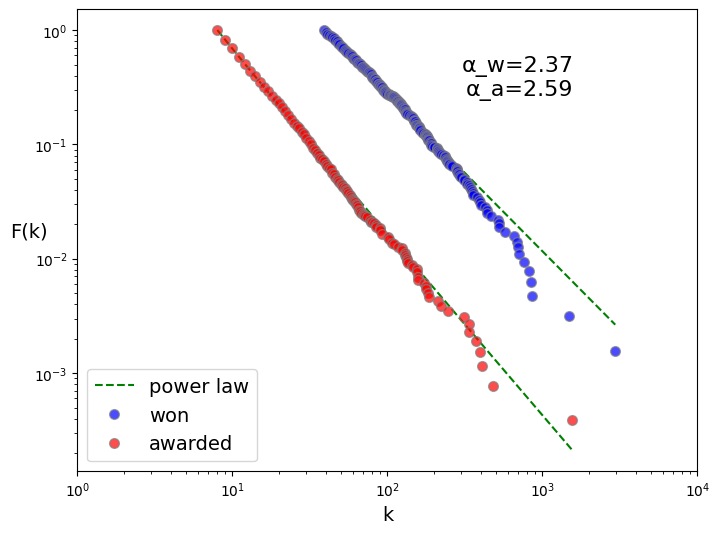

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

fit_won = powerlaw.Fit(degrees_i, discrete=True)
fit_awarded = powerlaw.Fit(degrees_w, discrete=True)

fit_won.power_law.plot_ccdf(color='green', linestyle='--', ax=ax, label='power law')
fit_awarded.power_law.plot_ccdf(color='green', linestyle='--', ax=ax)

fit_won.plot_ccdf(ax=ax, color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='blue', markeredgecolor='gray', label='won', alpha=0.7)
fit_awarded.plot_ccdf(ax=ax, color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='red', markeredgecolor='gray', label='awarded', alpha=0.7)

ax.legend(loc='lower left', fontsize=14)
plt.text(0.8, 0.9, f'α_w={fit_won.alpha:.2f}\nα_a={fit_awarded.alpha:.2f}', fontsize=16, transform=ax.transAxes, ha='right', va='top')

# set x-axis limits and ticks
x_min = 1
x_max = 10000
xticks = [1, 10, 100, 1000, 10000]
ax.set_xlim(x_min, x_max)
ax.set_xticks(xticks)

# set axis labels
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('F(k)', fontsize=14, rotation=0)

# set plot title
# ax.set_title('Power Law Distribution of Awarded and Won Contracts', fontsize=16)

# plt.savefig('../output/figures/DE_power_law_dist' + '.png', bbox_inches='tight')
plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


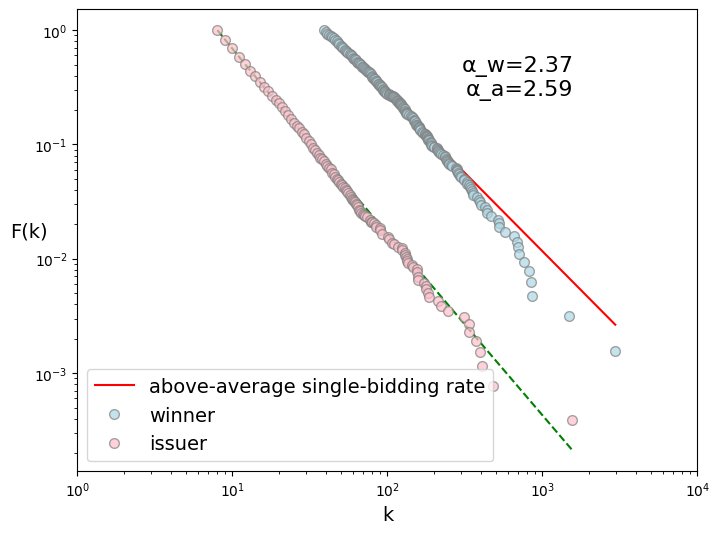

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

fit_won = powerlaw.Fit(degrees_i, discrete=True)
fit_awarded = powerlaw.Fit(degrees_w, discrete=True)

fit_won.power_law.plot_ccdf(color='red', linestyle='-', ax=ax, label='above-average single-bidding rate')
fit_awarded.power_law.plot_ccdf(color='green', linestyle='--', ax=ax)

fit_won.plot_ccdf(ax=ax, color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='lightblue', markeredgecolor='gray', label='winner', alpha=0.7)
fit_awarded.plot_ccdf(ax=ax, color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='pink', markeredgecolor='gray', label='issuer', alpha=0.7)

ax.legend(loc='lower left', fontsize=14)
plt.text(0.8, 0.9, f'α_w={fit_won.alpha:.2f}\nα_a={fit_awarded.alpha:.2f}', fontsize=16, transform=ax.transAxes, ha='right', va='top')

# set x-axis limits and ticks
x_min = 1
x_max = 10000
xticks = [1, 10, 100, 1000, 10000]
ax.set_xlim(x_min, x_max)
ax.set_xticks(xticks)

# set axis labels
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('F(k)', fontsize=14, rotation=0)

# set plot title
# ax.set_title('Power Law Distribution of Awarded and Won Contracts', fontsize=16)

# plt.savefig('../output/figures/DE_power_law_dist' + '.png', bbox_inches='tight')
plt.show()

In [32]:
# create subgraph DE per year
for year in range(2008, 2017):
  country = "DE"

  contracts_merged_DE_year = contracts_merged_DE[(contracts_merged_DE['year']==year)]

  globals()[f"{country}_{year}"] = nx.from_pandas_edgelist(contracts_merged_DE_year, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'count','n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'sbr_above_ave', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

  # set node attributes for issuer
  issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
  issuer_attributes = contracts_merged_DE[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
  nx.set_node_attributes(globals()[f"{country}_{year}"], issuer_attributes, 'issuer')

  # set node attributes for winner
  winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
  winner_attributes = contracts_merged_DE[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
  nx.set_node_attributes(globals()[f"{country}_{year}"], winner_attributes, 'winner')

In [34]:
for year in range(2008, 2017):
    country = "DE"

    # get largest connected component
    # Check if the graph has edges before finding connected components
    if globals()[f"{country}_{year}"].number_of_edges() > 0:
        connected_component_subgraphs = (globals()[f"{country}_{year}"].subgraph(c) for c in nx.connected_components(globals()[f"{country}_{year}"]))
        globals()[f"{country}_{year}_largest_subgraph"] = max(connected_component_subgraphs, key=len)
    else:
        # Handle the case where the graph is empty or has no edges
        print(f"Warning: Graph for {country} in {year} is empty or has no edges. Skipping...")
        globals()[f"{country}_{year}_largest_subgraph"] = None  # or any other appropriate value

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


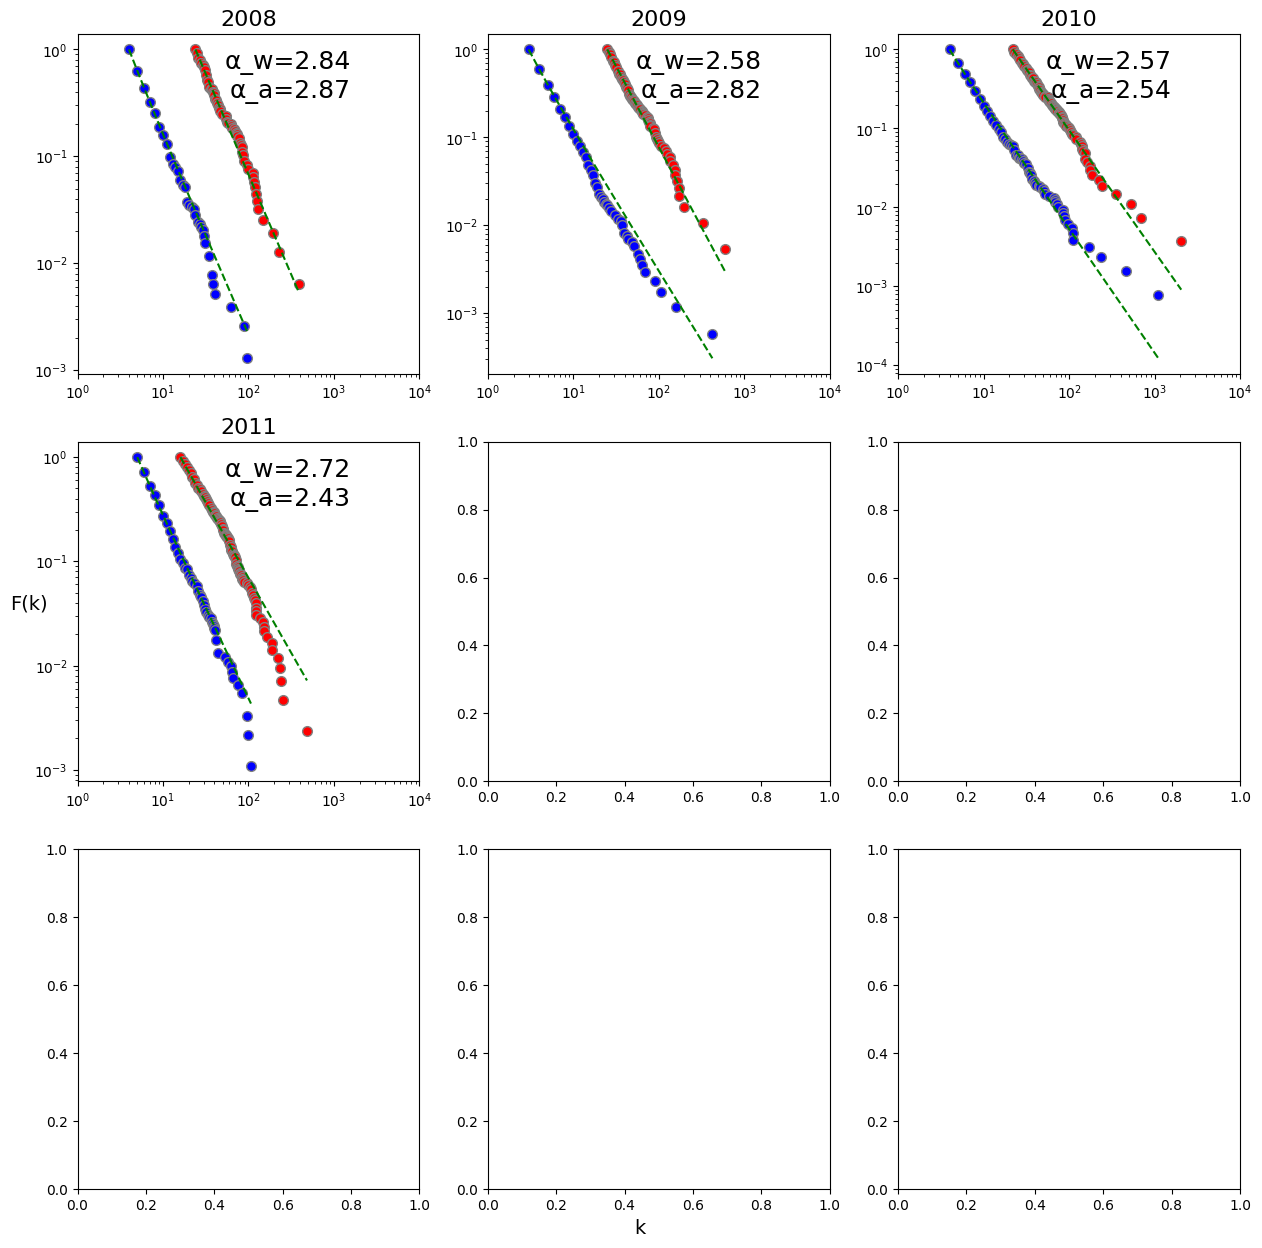

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

# set same x-axis limits and ticks for all subplots
x_min = 1
x_max = 10000
xticks = [1, 10, 100, 1000, 10000]

for i, year in enumerate(range(2008, 2012)):
    country = "DE"
    degrees_i = [deg for node, deg in globals()[f"{country}_{year}_largest_subgraph"].degree() if node.endswith('i')]
    degrees_w = [deg for node, deg in globals()[f"{country}_{year}_largest_subgraph"].degree() if node.endswith('w')]

    fit_won = powerlaw.Fit(degrees_w, discrete=True)
    fit_awarded = powerlaw.Fit(degrees_i, discrete=True)

    fit_won.plot_ccdf(ax=axs[i//3][i%3], color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='blue', markeredgecolor='gray', label='won')
    fit_awarded.plot_ccdf(ax=axs[i//3][i%3], color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='red', markeredgecolor='gray', label='awarded')

    fit_won.power_law.plot_ccdf(ax=axs[i//3][i%3], color='green', linestyle='--')
    fit_awarded.power_law.plot_ccdf(ax=axs[i//3][i%3], color='green', linestyle='--')

    axs[i//3][i%3].set_title(str(year), fontsize=16)
    # axs[i//3][i%3].legend(loc='lower left')
    axs[i//3][i%3].text(0.8, 0.95, f'α_w={fit_won.alpha:.2f}\nα_a={fit_awarded.alpha:.2f}', fontsize=18, transform=axs[i//3][i%3].transAxes, ha='right', va='top')

    # set x-axis limits and ticks
    axs[i//3][i%3].set_xlim(x_min, x_max)
    axs[i//3][i%3].set_xticks(xticks)

# set main axis labels
fig.text(0.5, 0.08, 'k', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'F(k)', va='center', fontsize=14)
ax.legend(loc='lower left', fontsize=14)

plt.show()

In [40]:
# create dataframe of summary statistics of largest connected component
DE_summ = pd.DataFrame(columns = ['year', 'nedges', 'nodes', 'winners', 'issuers', 'density', 'rac', #'wd_w', 'sd_w', 'wd_i', 'sd_i',
                                  'avg_degree', 'std_dev', 'd_w', 'sd_ww', 'd_i', 'sd_ii'])

weight = 'count'
for year in range(2008, 2017):
  country = "DE"

  DE = globals()[f"{country}_{year}_largest_subgraph"]

  # Check if DE is not None before proceeding
  if DE is not None:

    n_edges = DE.number_of_edges()

    n_nodes = DE.number_of_nodes()

    # n_nodes issuers
    issuer_nodes = [node for node in DE.nodes() if node.endswith('i')]
    issuer_subgraph = DE.subgraph(issuer_nodes)
    n_issuer_nodes = issuer_subgraph.number_of_nodes()

    # n_nodes winners
    winner_nodes = [node for node in DE.nodes() if node.endswith('w')]
    winner_subgraph = DE.subgraph(winner_nodes)
    n_winner_nodes = winner_subgraph.number_of_nodes()

    # degrees
    degrees = [deg for node, deg in DE.degree()]
    avg_degree = sum(degrees)/len(degrees)
    std_dev = np.nanstd(degrees)

    degrees_i = [deg for node, deg in DE.degree() if node.endswith('i')]
    avg_degree_i = sum(degrees_i)/len(degrees_i)
    std_dev_i = np.nanstd(degrees_i)

    degrees_w = [deg for node, deg in DE.degree() if node.endswith('w')]
    avg_degree_w = sum(degrees_w)/len(degrees_w)
    std_dev_w = np.nanstd(degrees_w)

    density = nx.density(DE)
    # bipartite.density(DE, issuer_nodes)

    rac = bipartite.robins_alexander_clustering(DE)

    row = pd.DataFrame({'year':year, 'nedges':n_edges, 'nodes':n_nodes,  # Changed 'edges' to 'nedges'
                        'winners':n_winner_nodes, 'issuers':n_issuer_nodes,
                        'density':density, 'rac':rac,
                        'avg_degree':avg_degree, 'std_dev':std_dev,
                        'd_w':avg_degree_w, 'sd_ww':std_dev_w,
                        'd_i':avg_degree_i, 'sd_ii':std_dev_i,}, index=[0])

    DE_summ = pd.concat([DE_summ.loc[:], row]).reset_index(drop=True)
  else:
    # Handle the case where DE is None (e.g., add a row with NaN values)
    row = pd.DataFrame({'year': year, 'nedges': np.nan, 'nodes': np.nan, 'winners': np.nan,  # Changed 'edges' to 'nedges'
                        'issuers': np.nan, 'density': np.nan, 'rac': np.nan,
                        'avg_degree': np.nan, 'std_dev': np.nan, 'd_w': np.nan,
                        'sd_ww': np.nan, 'd_i': np.nan, 'sd_ii': np.nan}, index=[0])
    DE_summ = pd.concat([DE_summ.loc[:], row]).reset_index(drop=True)

DE_summ

<ipython-input-40-e4cb32c2e4a9>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DE_summ = pd.concat([DE_summ.loc[:], row]).reset_index(drop=True)


year nedges  nodes winners issuers   density       rac  avg_degree  \
0  2008  16639  11168    9143    2025  0.000267  0.011395    2.979764   
1  2009  20935  13004   10526    2478  0.000248  0.010529    3.219779   
2  2010  27560  14663   12209    2454  0.000256  0.022871    3.759122   
3  2011  25705  15000   12451    2549  0.000229  0.015570    3.427333   
4  2012  13639   9089    7504    1585  0.000330  0.016130    3.001210   
5  2013    NaN    NaN     NaN     NaN       NaN       NaN         NaN   
6  2014    NaN    NaN     NaN     NaN       NaN       NaN         NaN   
7  2015    NaN    NaN     NaN     NaN       NaN       NaN         NaN   
8  2016    NaN    NaN     NaN     NaN       NaN       NaN         NaN   

     std_dev       d_w      sd_ww        d_i      sd_ii  
0   8.026736  1.819862   2.667475   8.216790  17.020566  
1  10.393466  1.988885   5.373082   8.448345  20.260301  
2  22.950155  2.257351  11.863454  11.230644  48.784339  
3   9.774698  2.064493   3.570433  10.084347  21.132685  
4   7.586933  1.817564   2.717933   8.605047  16.033419  
5        NaN       NaN        NaN        NaN        NaN  
6        NaN       NaN        NaN        NaN        NaN  
7        NaN       NaN        NaN        NaN        NaN  
8        NaN       NaN        NaN        NaN        NaN

In [43]:
# prompt: extrae a excel

import pandas as pd
import xlsxwriter
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('DE_summary_statistics.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
DE_summ.to_excel(writer, sheet_name='Sheet1', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.close() # Changed from writer.save() to writer.close()


In [46]:
# create k-core
for year in range(2008, 2012):
  country = "DE"

  # Check if the largest subgraph exists for this year
  if globals()[f"{country}_{year}_largest_subgraph"] is not None:
    degrees = [deg for node, deg in globals()[f"{country}_{year}_largest_subgraph"].degree()]
    avg_degree = sum(degrees)/len(globals()[f"{country}_{year}_largest_subgraph"])

    print(round(avg_degree, 0))

    DE_simple = nx.Graph(globals()[f"{country}_{year}_largest_subgraph"]) # convert multigraph to simple graph
    globals()[f"{country}_{year}_k_core"] = nx.k_core(DE_simple, k=round(avg_degree, 0)) # compute k-core on simple graph
  else:
    print(f"Warning: No largest subgraph found for {country} in {year}. Skipping k-core calculation.")

3.0
3.0
4.0
3.0


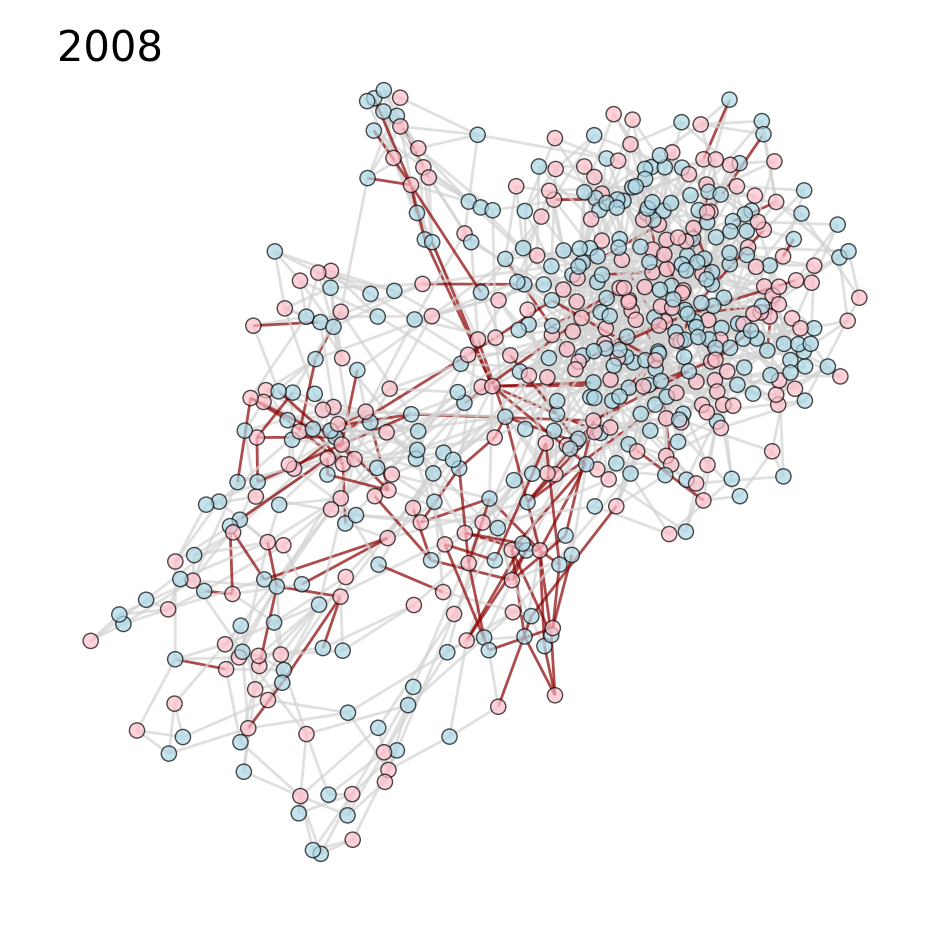

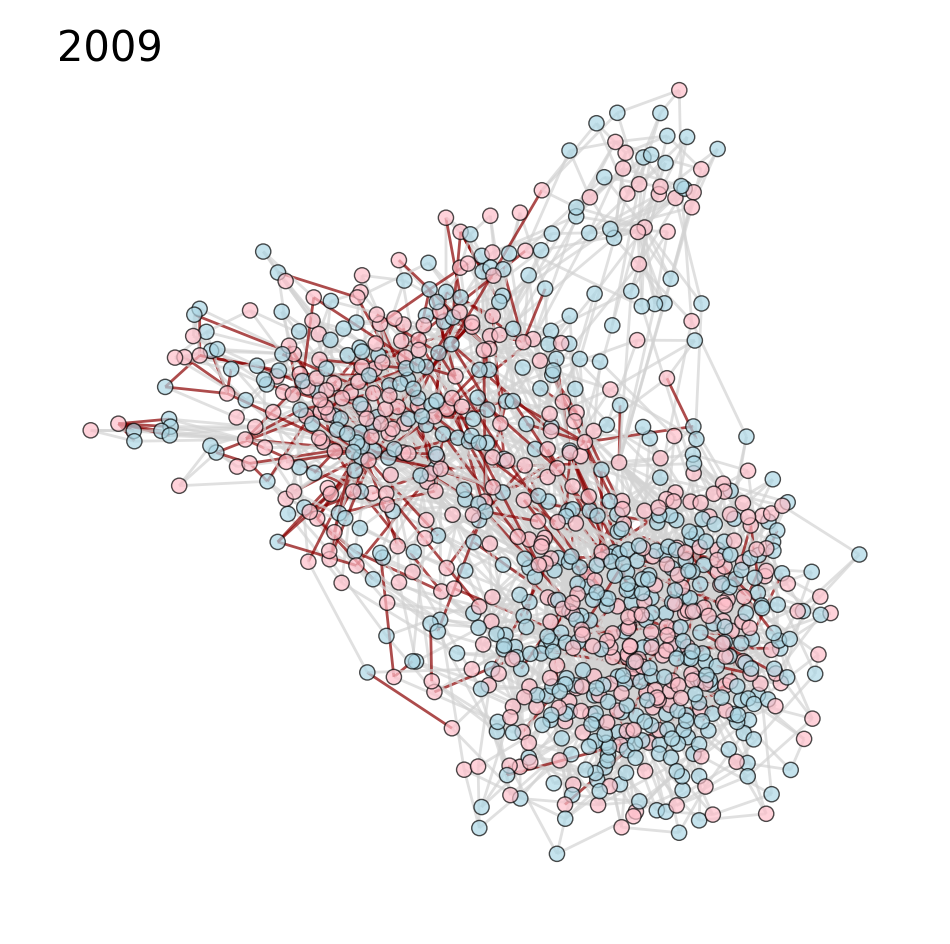

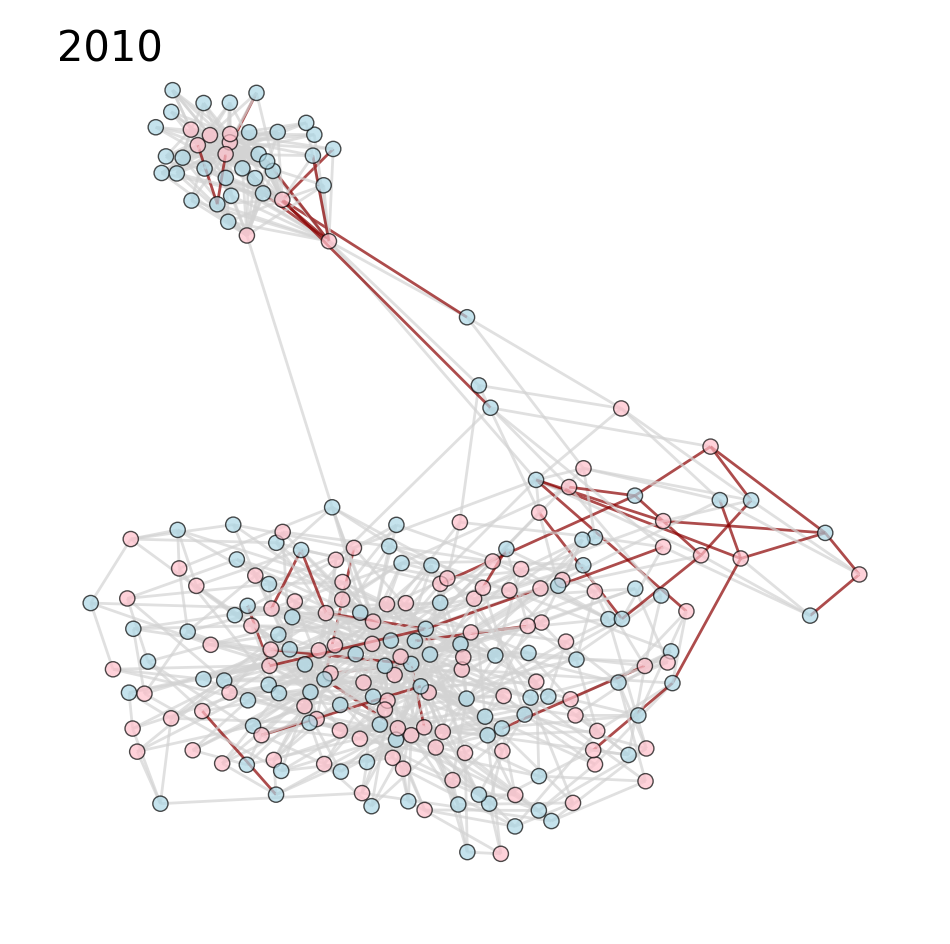

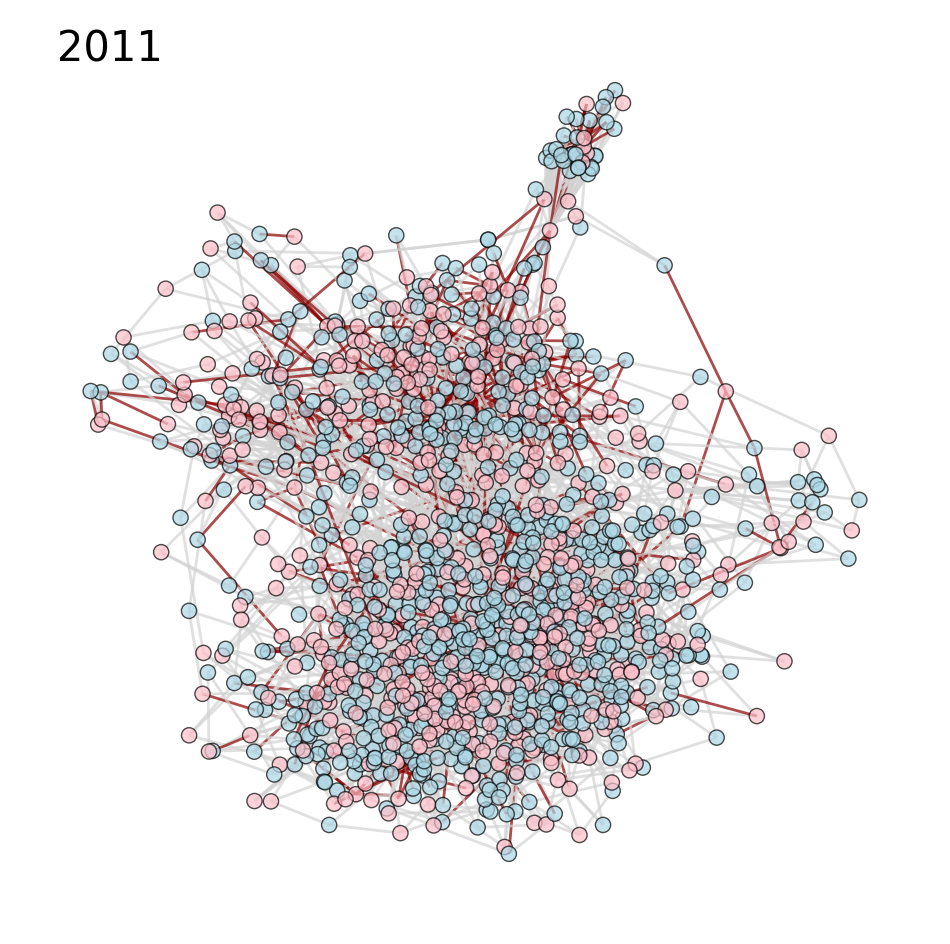

In [48]:
# plot k-core
for year in range(2008, 2012):
    country = "DE"

    fig, ax = plt.subplots(figsize=(12,12))

    ax.text(0.05, 0.98, f"{year}", fontsize=30, transform=ax.transAxes, ha='left', va='top')

    seed=1
    random.seed(seed)

    # Nodes
    node_size = 120
    node_colors = ['pink' if node.endswith('i') else 'lightblue' if node.endswith('w') else 'blue' for node in globals()[f"{country}_{year}_k_core"].nodes()]

    # Edges
    edge_colors = ['darkred' if globals()[f"{country}_{year}_k_core"].get_edge_data(*edge)['sbr_above_ave']==1 else 'lightgrey' for edge in globals()[f"{country}_{year}_k_core"].edges()]

    # Plot the graph
    pos = nx.spring_layout(globals()[f"{country}_{year}_k_core"], seed=seed, scale=2)
    nx.draw(globals()[f"{country}_{year}_k_core"], pos, with_labels=False, edgecolors='black', node_size=node_size, node_color=node_colors,
            edge_color=edge_colors, width=2, alpha = 0.7) #width=list(weights.values())

    #plt.savefig('../output/figures/k_core_largest_' + str(country) + "_" + str(year) + '.png', bbox_inches='tight')
    plt.show()

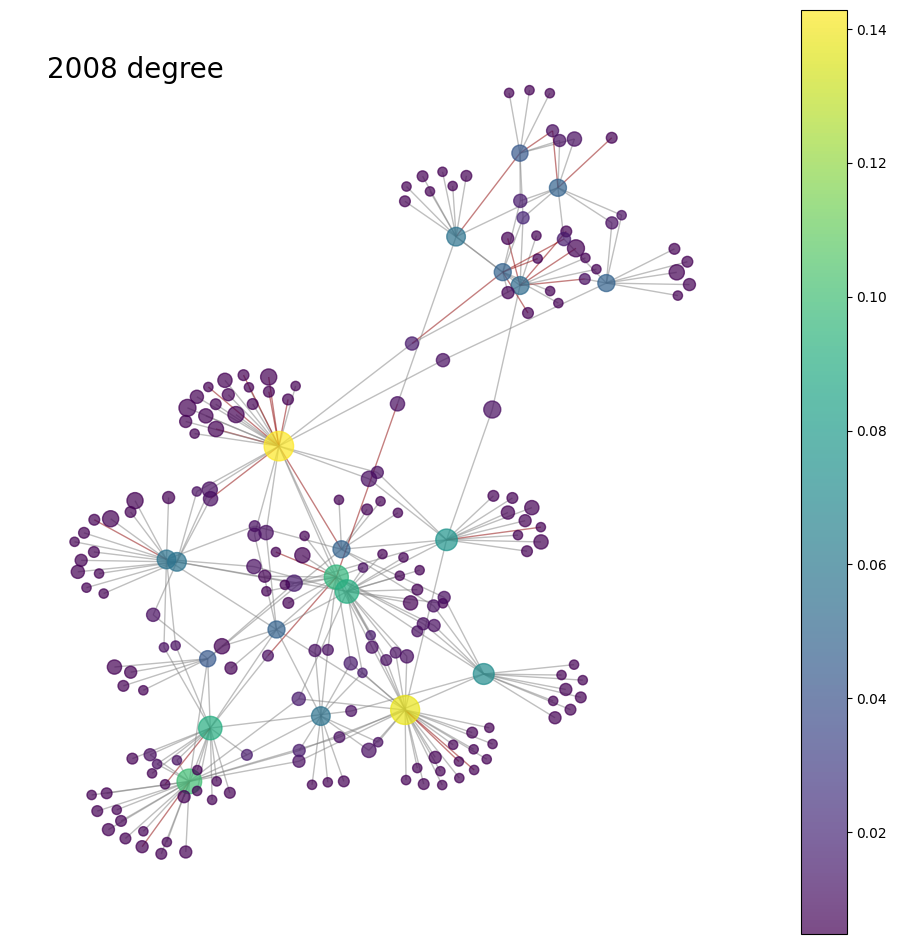

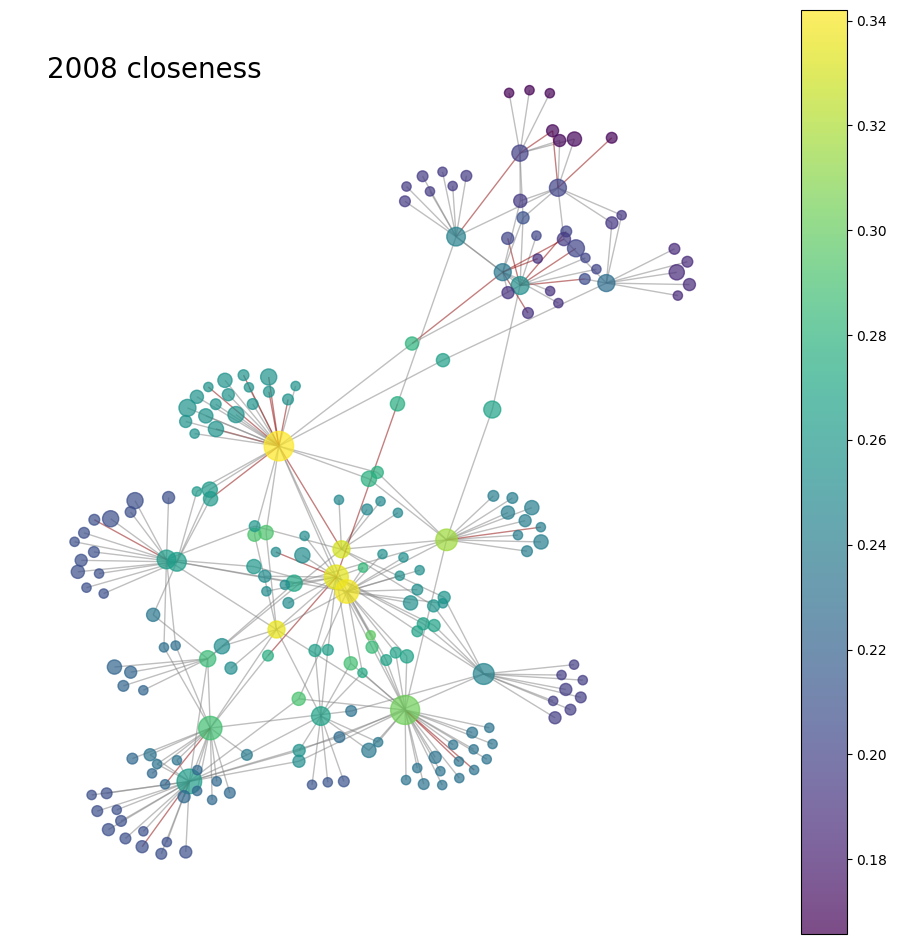

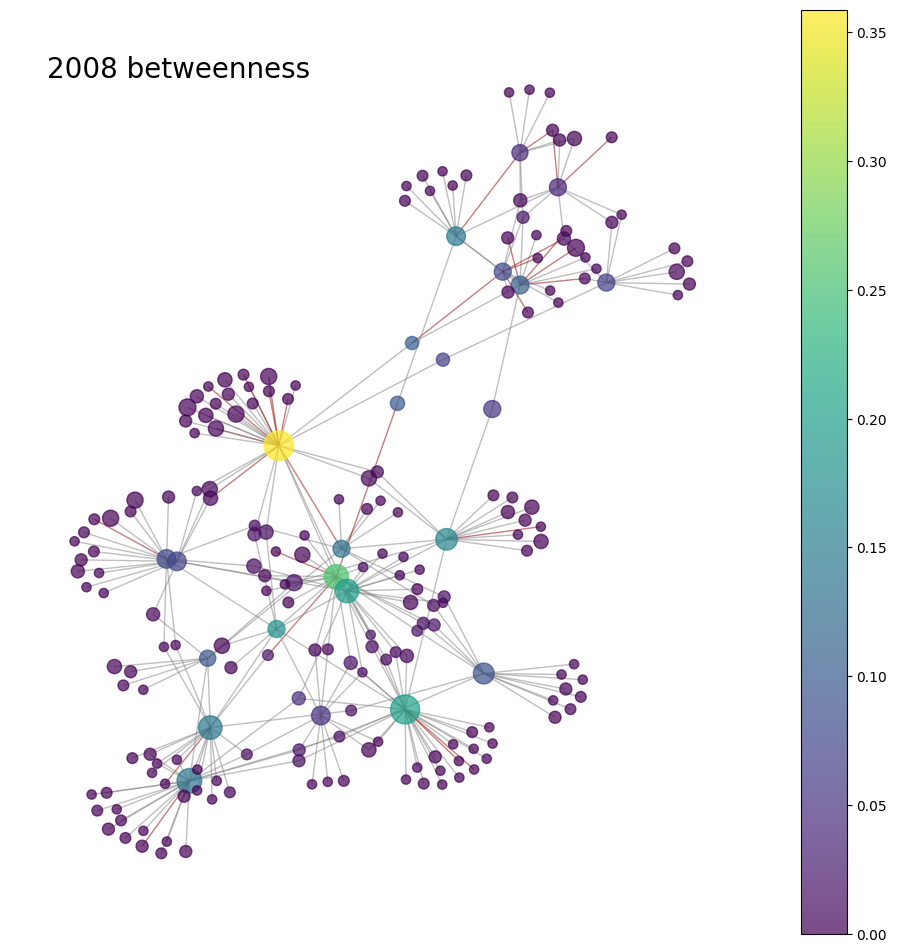

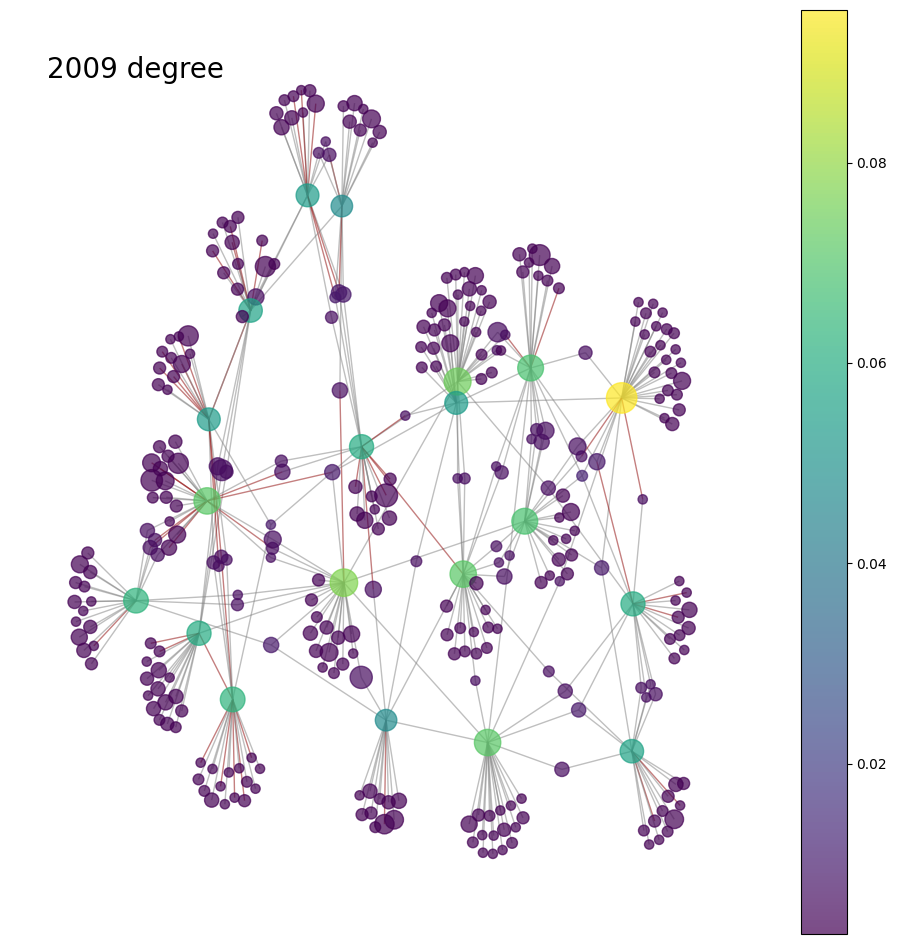

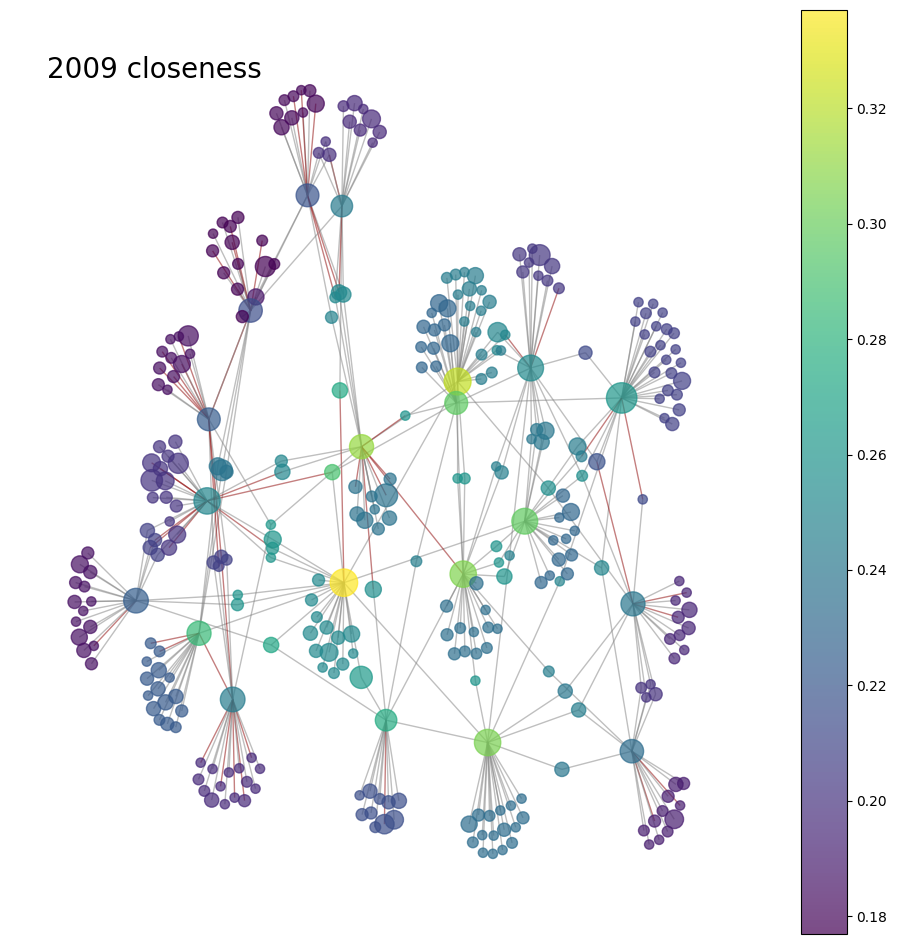

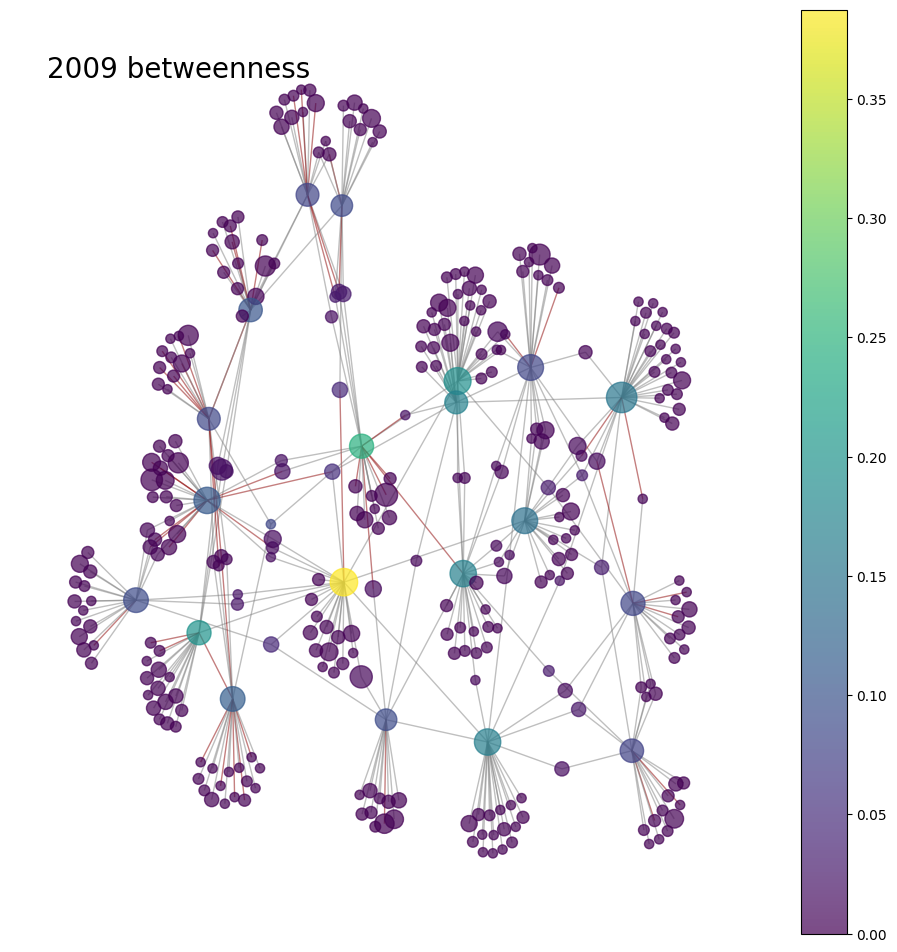

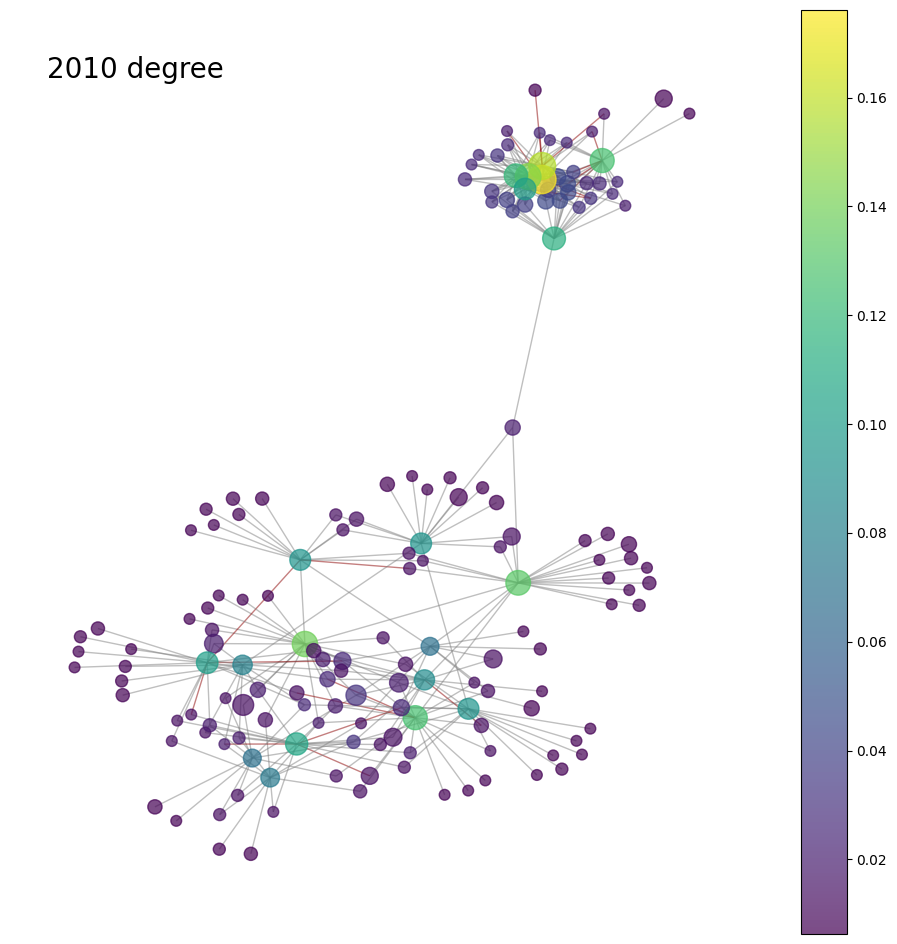

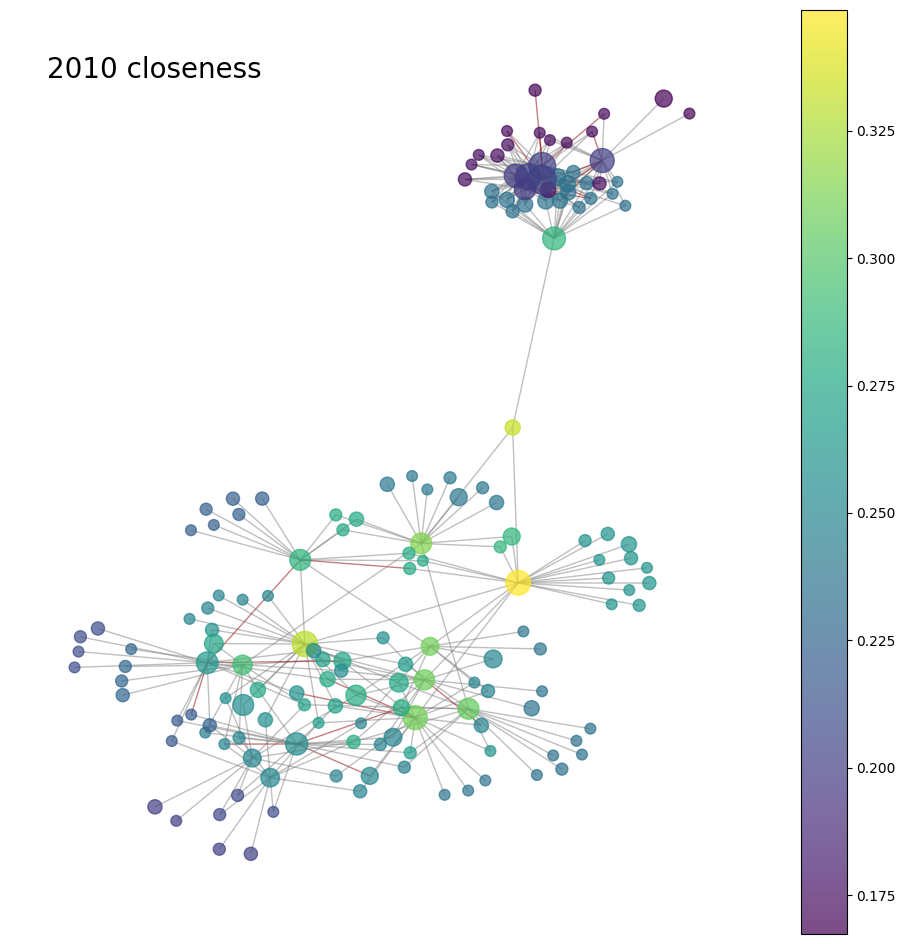

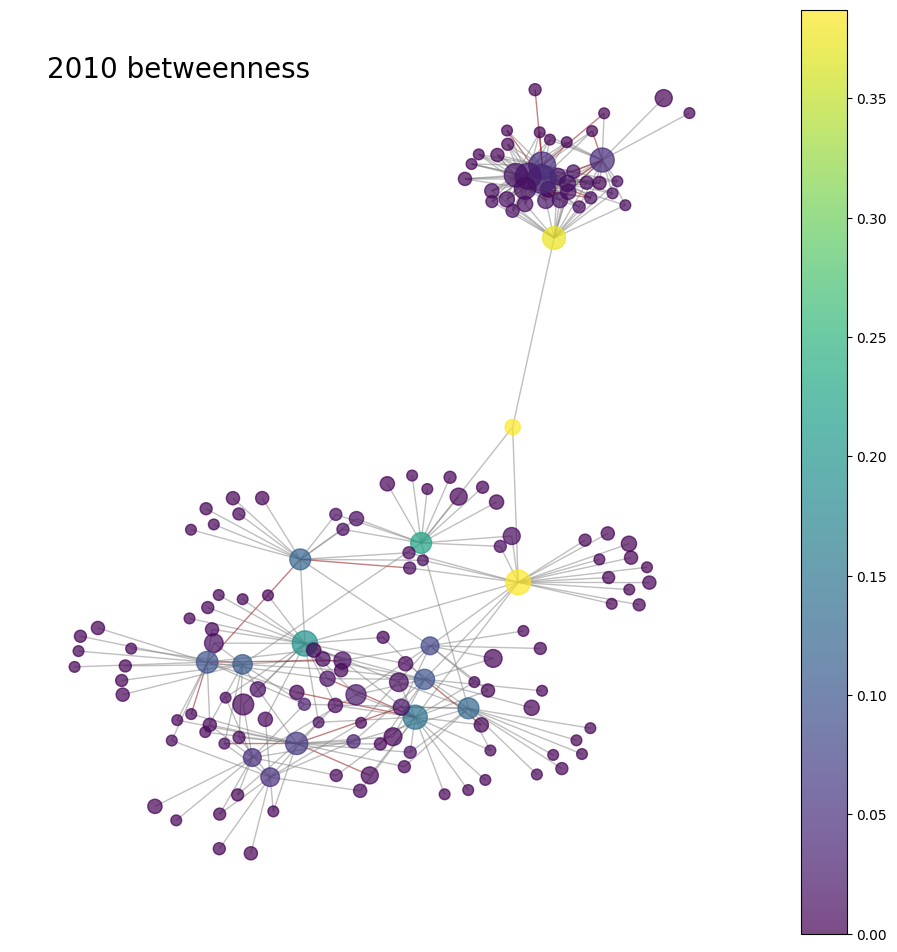

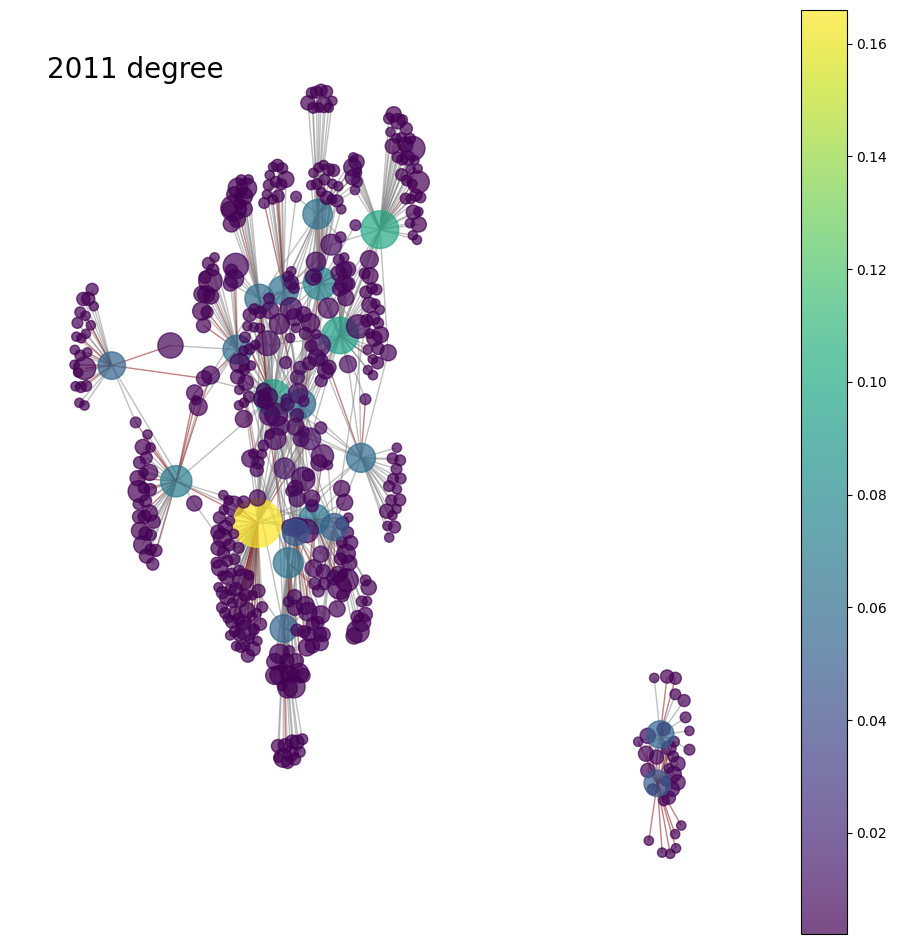

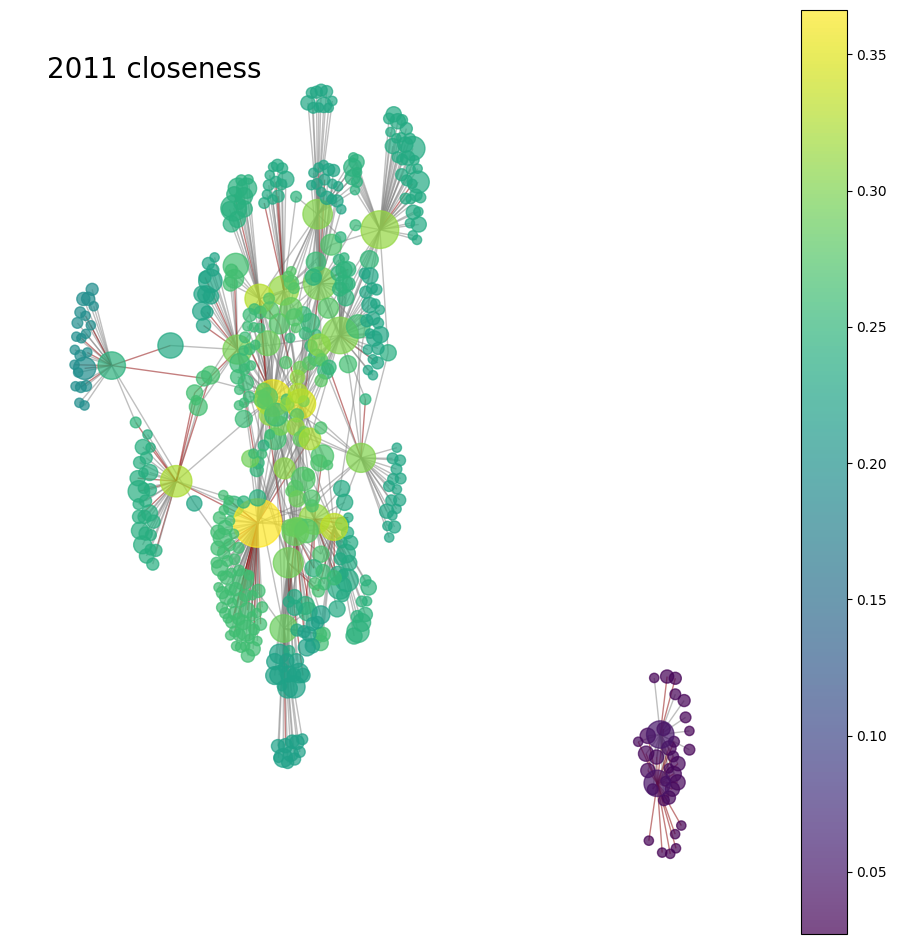

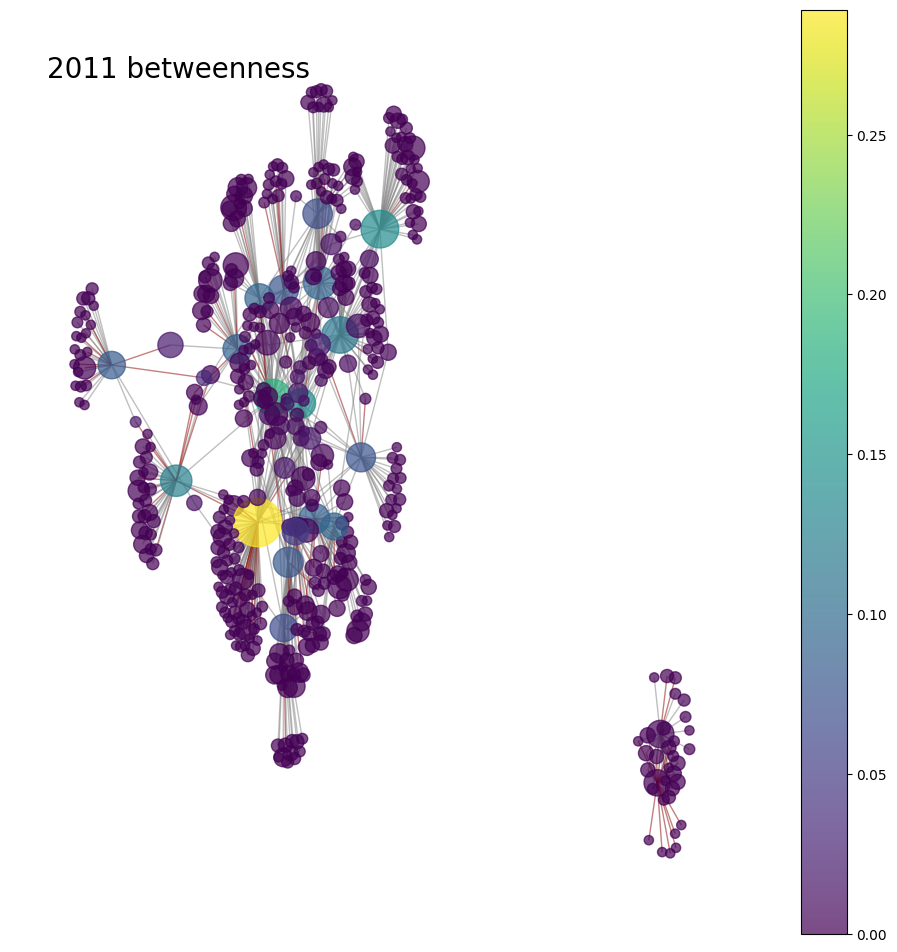

In [49]:
# Compute node centrality
for year in range(2008, 2012):
    DE = globals()[f"DE_{year}_k_core"]
    issuer_nodes = {node for node in DE.nodes() if node.endswith('i')}
    winner_nodes = {node for node in DE.nodes() if node.endswith('w')}
    n_hubs = 10

    # Calculate degree centrality for all nodes
    degree_centrality = {node: deg for node, deg in DE.degree()}

    # Store the degree of nodes in a dictionary
    degrees = {node: deg for node, deg in DE.degree()}

    # Sort nodes by degree centrality and select the top n_hubs nodes for winners and issuers
    sorted_winners = sorted([(node, deg) for node, deg in degree_centrality.items() if node in winner_nodes],
                            key=lambda x: x[1], reverse=True)
    sorted_issuers = sorted([(node, deg) for node, deg in degree_centrality.items() if node in issuer_nodes],
                            key=lambda x: x[1], reverse=True)

    top_winners = [node[0] for node in sorted_winners[:n_hubs]]
    top_issuers = [node[0] for node in sorted_issuers[:n_hubs]]

    # Create subgraphs of hubs and their connected nodes
    hub_subgraphs = []
    for hub in top_winners + top_issuers:
        nodes_to_add = list(DE.neighbors(hub)) + [hub]
        subgraph = DE.subgraph(nodes_to_add)
        hub_subgraphs.append(subgraph)

    # Combine hub subgraphs into a single graph
    year_graph = nx.Graph()
    for subgraph in hub_subgraphs:
        year_graph = nx.compose(year_graph, subgraph)

    # Save the resulting graph
    globals()[f"hub_graph_{year}"] = year_graph

    random.seed(seed)
    degree = nx.degree_centrality(year_graph)
    closeness = nx.closeness_centrality(year_graph)
    betweenness = nx.betweenness_centrality(year_graph)

    for c_name, c in [('degree', degree), ('closeness', closeness), ('betweenness', betweenness)]:
        # Draw the graph with nodes colored by centrality measure
        pos = nx.spring_layout(year_graph, seed=seed)
        fig, ax = plt.subplots(figsize=(12,12))

        ax.text(0.05, 0.95, f"{year} {c_name}", fontsize=20, transform=ax.transAxes, ha='left', va='top')

        node_sizes = [degrees[node] * 15 for node in year_graph.nodes()]
        edge_colors = ['darkred' if year_graph.get_edge_data(*edge).get('sbr_above_ave')==1 else 'grey' for edge in year_graph.edges()]
        nx.draw_networkx_edges(year_graph, pos, alpha=0.5, edge_color=edge_colors)
        node_sm = nx.draw_networkx_nodes(year_graph, pos, node_color=list(c.values()), cmap=plt.cm.viridis, node_size=node_sizes, alpha=0.7,)

        # Add colorbar to the plot
        plt.colorbar(node_sm, ax=plt.gca())
        plt.axis('off')
        # Save the plot by year and centrality measure
        # plt.savefig(f'../output/figures/core_hub_centrality_{year}_{c_name}.png',bbox_inches='tight')